#Imports y definiciones

In [1]:
import sklearn as sk
import pandas as pd
import numpy as np
import joblib
#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

#modelos y métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score,make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV,GridSearchCV,cross_validate
# pre-procesamiento
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
#xgboost
import xgboost as xgb
#ensambles hibridos
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegressionCV

#RFC
!pip install 'dtreeviz'
import dtreeviz.trees as dtreeviz
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score
#
import numpy as np
import seaborn as sns
import joblib
import nltk
from nltk import tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import re

from six import StringIO
import pydotplus
from IPython.display import Image

from sklearn.tree import export_graphviz
#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.2 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
def mostrar_metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

#Preprocesamiento

In [3]:
# Cargamos el ds train y test
dsReviewTest = pd.read_csv("test.csv")
dsReviewTestCopy = dsReviewTest.copy()

df = pd.read_csv("train.csv")
ds_trabajo = df.copy()
# Semilla
SEED = 7

In [4]:
ds_trabajo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [5]:
ds_trabajo.sentimiento.value_counts()

positivo    25000
negativo    25000
Name: sentimiento, dtype: int64

In [6]:
#TODO elimar resenas que no estan en espanol(?)

## Definimos una funcion para quitar letras con tildes

In [7]:
def remove_tildes(text):
    remove = (("á", "a"),("é", "e"),("í", "i"),("ó", "o"),("ú", "u"))

    for a, b in remove:
        text = text.replace(a, b).replace(a.upper(), b.upper())
    return text

## Stop words
- Usaremos stopWords tanto en español como en ingles y les haremos un procesamiento para quitar las tildes.

In [8]:
# Por recomendacion generales de la comunidad, quitaremos las tildes de las stop words.
stop_words = stopwords.words("english") + stopwords.words("spanish")
stop_words = [remove_tildes(word) for word in stop_words]

## Vectorizacion
Para vectorizar utilizaremos TfidfVectorizer ya que por indicaciones de la catedra y pruebas del equipo suele ofrecer una mejora en el rendimiento.

### Parametros de TfidfVectorizer:
1.   **max_features:** Este parámetro especifica el número máximo de características (términos o palabras) que se deben extraer y tener en cuenta. Por ejemplo, en 2000, significa que solo se considerarán las 2000 palabras más frecuentes en el conjunto de documentos. Probamos con utilizar diversos valores en este campo, (1000, 2500, 5000) y el mejor resultado lo conseguimos dejandolo con valores default.

2.   **stop_words:** Este parámetro se utiliza para especificar una lista de palabras comunes que se deben omitir durante el proceso de vectorización. Las palabras "stop words" suelen ser palabras muy comunes en un idioma (como "the", "and", "is", etc.) que no aportan mucha información sobre el contenido del texto y pueden ser eliminadas para mejorar la eficiencia y la relevancia del análisis.

3. **strip_accents:** Este parámetro indica si se deben eliminar o reemplazar acentos y diacríticos durante el preprocesamiento del texto.

In [9]:
vectorizer = TfidfVectorizer(stop_words = stop_words, strip_accents = "unicode")

In [10]:
# mapeamos las etiquetas positivo, negativo a 1 y 0
ds_trabajo['sentimiento'] = ds_trabajo['sentimiento'].map({'positivo': 1, 'negativo': 0})

In [11]:
#Genero los conjuntos de train y de test
# target = 'sentimiento'
# ds_trabajo_x = ds_trabajo.drop([target,'ID'], axis='columns', inplace=False)
# ds_trabajo_y = ds_trabajo[target].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_trabajo.review_es,
                              ds_trabajo.sentimiento,
                              test_size = 0.2,
                              random_state = 7,
                              shuffle =True
                              )

#Bayes Naive

## Instancio, entreno y testeo modelos

Se entrenaran modelos Naive Bayes Multinomial y previamente se utilizaran los metodos Bag of Words e Inverse document frequency para evaluar que procesamiento de los datos conviene mas. A priori tendria que ser mas conveniente usar IDF.

In [104]:
model_tfid = make_pipeline(TfidfVectorizer(), MultinomialNB())
model_CV = make_pipeline(CountVectorizer(), MultinomialNB())

model_tfid.fit(x_train, y_train)
model_CV.fit(x_train, y_train)

model_tfid_prediction = model_tfid.predict(x_test)
model_CV_prediction = model_CV.predict(x_test)

## Evaluo y visualizo resultados

TFID:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      4985
           1       0.87      0.84      0.85      5015

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



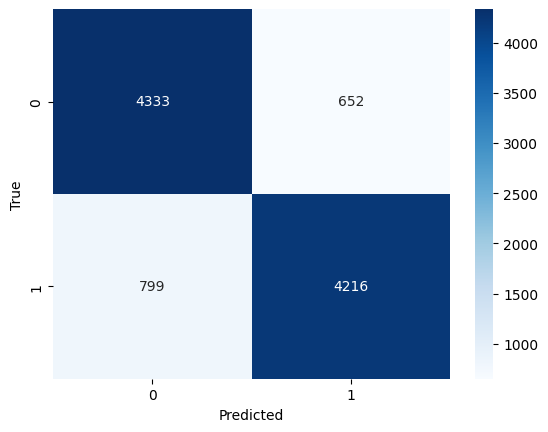

In [105]:
print("TFID:")
mostrar_metricas(model_tfid_prediction, y_test)

CV
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      4985
           1       0.87      0.80      0.83      5015

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



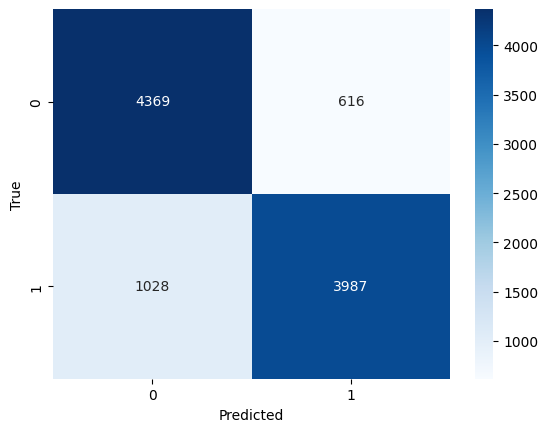

In [106]:
print("CV")
mostrar_metricas(model_CV_prediction,y_test)

Tal y como preveimos, TFI es superior.

## Busqueda de los mejores hiperparametros usando TfidfVectorizer

In [107]:

parameters = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'multinomialnb__alpha': [0.1, 0.5, 1.0],
}

optimized = make_pipeline(vectorizer, MultinomialNB())

grid_search = GridSearchCV(optimized, parameters, cv=5, n_jobs=-1, scoring=f1_score)

grid_search.fit(x_train, y_train)

# Imprimir los mejores parámetros encontrados
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

Mejores parámetros encontrados:
{'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (1, 1)}


In [108]:
#Exportamos
joblib.dump(best_model, 'nb.joblib')

['nb.joblib']

In [109]:
best_model = joblib.load('nb.joblib')

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      4985
           1       0.86      0.85      0.86      5015

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



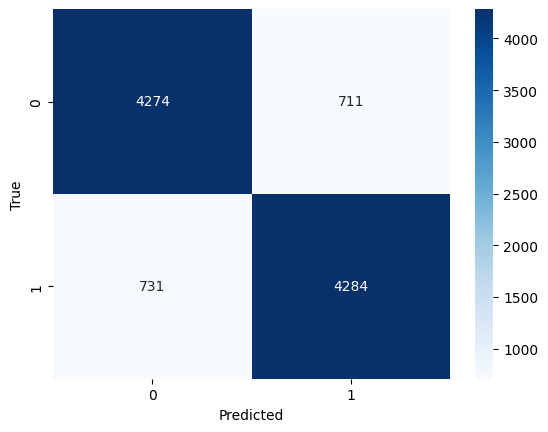

In [110]:
#evaluamos conjunto de test
y_pred = best_model.predict(x_test)
#mostramos resultados
mostrar_metricas(y_pred, y_test)

## Pasamos a evaluar con el conjunto test real

In [111]:
#prediccion contra el ds_test y guardamos submission
y_pred = best_model.predict(dsReviewTestCopy.review_es)
ds_submission = pd.DataFrame({'ID': dsReviewTest['ID'], 'sentimiento' : y_pred})
df_submission['sentimiento'] = df_submission['sentimiento'].map({1: 'positivo', 0: 'negativo'})
ds_submission.to_csv('nb.csv', index=False)
ds_submission.head()

,ID,sentimiento
0,60000,0
1,60001,0
2,60002,0
3,60003,1
4,60004,0


#RandomForest

In [112]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (40000,)
y_train shape: (40000,)


In [113]:
#Creamos un clasificador con hiperparámetros arbitrarios
rfc_no_optimizado = RandomForestClassifier(max_features='auto',
                        criterion="entropy",
                        min_samples_leaf=5,
                        min_samples_split=5,
                        n_estimators=30,
                        random_state=7,
                        class_weight="balanced",
                        n_jobs=-1,)
#Entrenamos el modelo
model = make_pipeline(vectorizer, rfc_no_optimizado)
model.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode')),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        max_features='auto', min_samples_leaf=5,
                                        min_samples_split=5, n_estimators=30,
                                        n_jobs=-1, random_state=7))])

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      4985
           1       0.83      0.82      0.83      5015

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



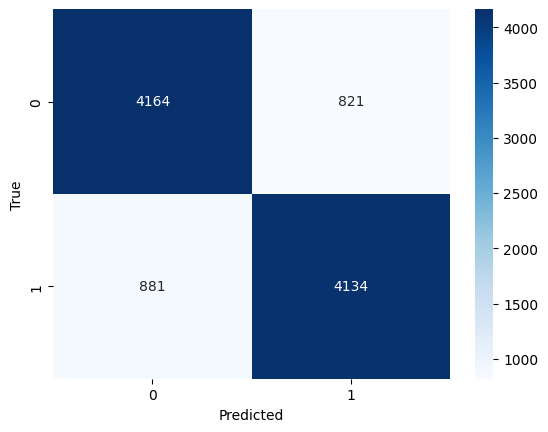

In [114]:
#Realizamos una predicción sobre el set de test
y_pred_rfc_no_optimo = model.predict(x_test)
#grafico matriz de confusion y metricas
mostrar_metricas(y_pred_rfc_no_optimo,y_test)

In [115]:
#Exportamos
joblib.dump(rfc_no_optimizado, 'rfc_no_optimizado.joblib')

['rfc_no_optimizado.joblib']

In [116]:
#pruebo contra el ds test y lo exporto
y_pred = model.predict(dsReviewTest.review_es)
ds_submission = pd.DataFrame({'ID': dsReviewTest['ID'], 'sentimiento': y_pred})
df_submission['sentimiento'] = df_submission['sentimiento'].map({1: 'positivo', 0: 'negativo'})
ds_submission.to_csv('./rfc_no_optimizado.csv', index=False)

##Optimizamos hiperparametros con GridSearch CV

In [13]:
rf_cv = RandomForestClassifier(max_features='auto', random_state=7, n_jobs=-1,class_weight="balanced")
kfoldcv = StratifiedKFold(n_splits=5)
scorer_fn = make_scorer(f1_score)
param_grid = { "randomforestclassifier__criterion" : ["gini", "entropy"],
          "randomforestclassifier__min_samples_leaf" : [1, 2, 5],
          "randomforestclassifier__min_samples_split" : [2, 4, 10],
          "randomforestclassifier__n_estimators": [ 30, 40, 50 ] }

model = make_pipeline(vectorizer, rf_cv)
#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=model,
                  param_grid=param_grid,
                  scoring = scorer_fn,
                  cv=kfoldcv,
                  n_jobs=-1)
gs_fit = gs.fit(X = x_train, y = y_train)

In [14]:
#mostramos la mejor config de hiperparametros
gs_fit.best_params_

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 40}

In [15]:
#el mejor f1_score
print("f1_score en entrenamiento con cv: "+str(gs_fit.best_score_))

f1_score en entrenamiento con cv: 0.8255532221148364


              precision    recall  f1-score   support

           0       0.83      0.84      0.84      4985
           1       0.84      0.83      0.83      5015

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



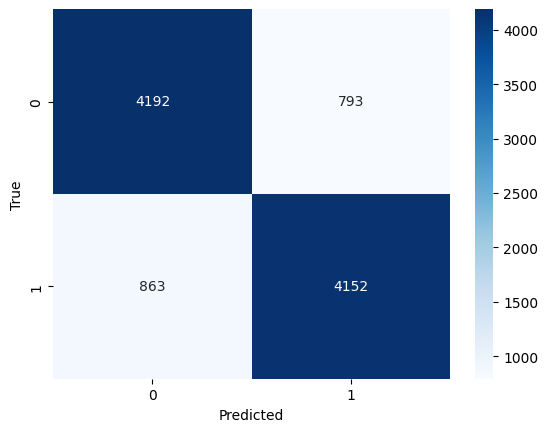

In [16]:
#Obtenemos el mejor modelo
rf_cv_best = gs_fit.best_estimator_
#exportamos
joblib.dump( rf_cv_best, 'random_forest_optimizado_f1_score.joblib')
#Predicción grafico y metricas
y_pred_rf_cv_best = rf_cv_best.predict(x_test)

mostrar_metricas(y_pred_rf_cv_best,y_test)


In [19]:
#prediccion contra el ds_test y guardamos submission
y_pred = rf_cv_best.predict(dsReviewTestCopy.review_es)
ds_submission = pd.DataFrame({'ID': dsReviewTest['ID'], 'sentimiento' : y_pred})
ds_submission['sentimiento'] = ds_submission['sentimiento'].map({1: 'positivo', 0: 'negativo'})
ds_submission.to_csv('./rfc_optimizado_f1_score_10_folds.csv', index=False)
ds_submission.head()

,ID,sentimiento
0,60000,negativo
1,60001,negativo
2,60002,negativo
3,60003,negativo
4,60004,positivo


#XGBoost

## Instancio, entreno y testeo modelos

Se entrenaran modelos Naive Bayes Multinomial utilizando una tokenizacion con el *vectorizer* creado anteriormente.

In [37]:
model_tfid = make_pipeline(vectorizer, xgb.XGBClassifier(random_state=7, n_estimators=100))

model_tfid.fit(x_train, y_train)

model_tfid_prediction = model_tfid.predict(x_test)

## Evaluo y visualizo resultados

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      4985
           1       0.83      0.86      0.84      5015

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



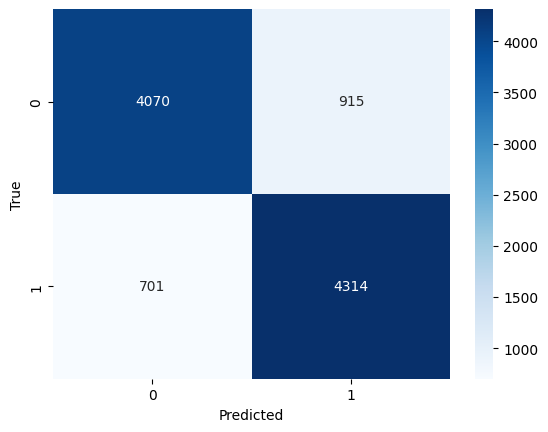

In [38]:
# mostramos resultados
mostrar_metricas(model_tfid_prediction, y_test)

##Busqueda de los mejores hiperparametros

In [40]:
parameters = {
}

# Los siguientes parametros fueron especialmente seleccionados ya que fueron los mas optimos al momento de optimizar los datos en otro cuaderno. En aquel cuaderno se realizo el mismo procesamiento de datos, pero en lugar
# de utilizar un pipeline, se realizo la vectorizacion previo a la separacion de conjuntos de tests y train. Sin embargo, haciendo la vectorizacion de esa manera se reciben peores resultados, asi que se decidio utilizar
# el pipeline y los parametros optimizados del modelo entrenado en la otra notebook.

# Sin embargo al intentar hacer optimizacion de hiperparametros con el pipeline tira error, no se porque. Asi que la mejor solucion fue esta.
optimized = make_pipeline(vectorizer, xgb.XGBClassifier(random_state=0,
                              subsample = 0.8,
                            n_estimators = 300,
                            min_child_weight = 1,
                            max_depth = 4,
                          learning_rate = 0.2,
                        colsample_bytree = 1.0))

grid_search = GridSearchCV(optimized, parameters, cv=5, n_jobs=-1)

grid_search.fit(x_train, y_train)

# Imprimir los mejores parámetros encontrados
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el rendimiento accuracy en el conjunto de prueba
accuracy = grid_search.score(x_test, y_test)
print(f"Precisión en el conjunto de prueba: {accuracy}")

best_model = grid_search.best_estimator_

Mejores parámetros encontrados:
{}
Precisión en el conjunto de prueba: 0.8559


In [47]:
#Exportamos
joblib.dump(best_model, 'xgboost.joblib')

['xgboost.joblib']

## Analisis de resultados

In [71]:
best_model = joblib.load('xgb.joblib')

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4985
           1       0.84      0.87      0.86      5015

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



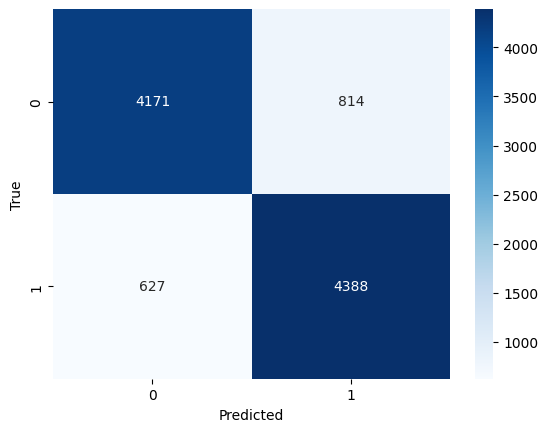

In [72]:
predict_best_model = best_model.predict(x_test)

# mostramos resultados
mostrar_metricas(predict_best_model, y_test)

## Pasamos a evaluar con el conjunto test real

In [73]:
y_pred = best_model.predict(dsReviewTest.review_es)
df_submission = pd.DataFrame({'id': dsReviewTestCopy['ID'], 'sentimiento': y_pred})
df_submission['sentimiento'] = df_submission['sentimiento'].map({1: 'positivo', 0: 'negativo'})
df_submission.to_csv('xgboost_fix.csv', index=False)

# Red neuronal

#Ensamble

La idea del ensambles es utilizar varios predictores debiles con el proposito de construir uno que en conjunto funcione mejor, aprovechando los modelos que entrenamos previamente armamos un ensamble de tipo Voting con XGBoost, RandomForest y Bayes Naive.

In [20]:
nb = joblib.load("nb.joblib")
xgb = joblib.load("xgb.joblib")
rf = joblib.load("rfc.joblib")

ensamble = VotingClassifier(estimators = [
    ('nb', nb),
    ('xgb', xgb),
    ('rf', rf)
])
ensamble.fit(x_train, y_train)


#TODO probar si mejora con cross validation

VotingClassifier(estimators=[('nb',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(stop_words=['i',
                                                                           'me',
                                                                           'my',
                                                                           'myself',
                                                                           'we',
                                                                           'our',
                                                                           'ours',
                                                                           'ourselves',
                                                                           'you',
                                                                           "you're",
                                                                           "you've",
                                                                           "you'll",
                                                                           "you'd",
                                                                           'your',
                                                                           'yours',
                                                                           'yourself',
                                                                           'yourselves',
                                                                           'he',
                                                                           'him',
                                                                           'his',
                                                                           'himself',
                                                                           'she',
                                                                           "she's",
                                                                           'her',
                                                                           'hers',
                                                                           'herself',
                                                                           'it',
                                                                           "it's",
                                                                           'its',
                                                                           'itself', ...],
                                                               strip_accents='unicode'...
                                                                           "you're",
                                                                           "you've",
                                                                           "you'll",
                                                                           "you'd",
                                                                           'your',
                                                                           'yours',
                                                                           'yourself',
                                                                           'yourselves',
                                                                           'he',
                                                                           'him',
                                                                           'his',
                                                                           'himself',
                                                                           'she',
                                                                           "she's",
                                                                           'her',
                                     

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      4985
           1       0.86      0.88      0.87      5015

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



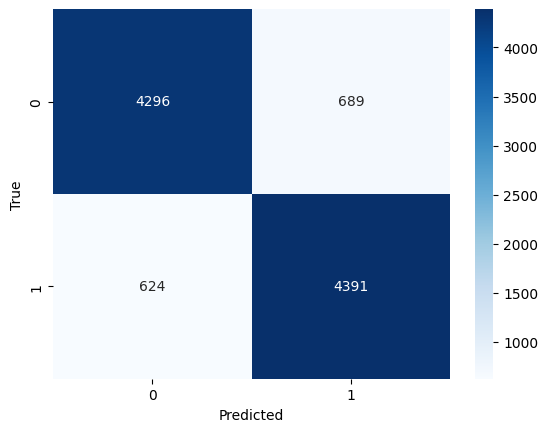

In [21]:
#evaluamos con el conjunto de prueba
predict_best_model = ensamble.predict(x_test)

# mostramos resultados
mostrar_metricas(predict_best_model, y_test)

In [22]:
#Exportamos
joblib.dump(ensamble, 'voting.joblib')

['voting.joblib']

##Evaluamos con el dsTest

In [23]:
y_pred = ensamble.predict(dsReviewTest.review_es)
df_submission = pd.DataFrame({'id': dsReviewTestCopy['ID'], 'sentimiento': y_pred})
df_submission['sentimiento'] = df_submission['sentimiento'].map({1: 'positivo', 0: 'negativo'})
df_submission.to_csv('voting_fix.csv', index=False)